# Project 2

It is October 2018. The squirrels in Central Park are running into a problem and we need your help.

For this project you must go through most steps in the checklist. You must write responses for all items however sometimes the item will simply be "does not apply". Some of the parts are a bit more nebulous and you simply show that you have done things in general (and the order doesn't really matter). Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Do not do the final part (launching the product) and your presentation will be done as information written in this document in a dedicated section, no slides or anything like that. It should however include the best summary plots/graphics/data points.

You are intentionally given very little information thus far. You must communicate with your client (me) for additional information as necessary. But also make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

You must submit all data files and a pickled preprocessor and final model along with this notebook.

### **Objective**

- There is an outbreak affecting squirrels in Central Park, and we need to try and identify and manage the diseased ones using data from the Squirrel Census, which includes approximately 3,000 squirrel sightings. We aim to determine which squirrels tested positive for the disease and analyze these sightings to uncover patterns or indicators that could help predict the presence of the disease. It's important to note that squirrel behavior varies by type, and certain diseases may be influenced by fluctuating weather conditions. By understanding these factors, we hope to develop a more effective strategy for managing the outbreak.


### *Imports Goes Here*

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


# **Get the Data**
1. **List the data you need and how much you need:**
    - Need weather data because squirrel sightings might vary per type of weather.
    - daily NYC Weather data
2. **Find and document where you can get that data:**
    - Publicly available from: [Kaggle](https://www.kaggle.com/datasets/aadimator/nyc-weather-2016-to-2022)
3. **Get access authorizations**: None needed, publicly available.


### *Loading Datasets...*

- To prepare for merging data later, we start by loading the necessary datasets



In [31]:
squirrel_data = pd.read_csv("2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20241105.csv")
weather_data = pd.read_csv("NYC_Weather_2016_2022.csv")

### *Functions for Cleaning and Merging Data*
- In new dataset. (i.e. samples with dates that don't have a squirrel sighting on the same day.)
- The `retrieve_weather_days` function filters the weather data to include only dates when squirrel sightings occurred. The `merge_datasets` function then combines the squirrel and weather datasets based on these matching dates.


In [32]:
import pandas as pd

def retrieve_weather_days(weather_dataset, squirrel_dataset):
    squirrel_dataset["Date"] = pd.to_datetime(squirrel_dataset["Date"], format='%m%d%Y')
    sighting_dates = squirrel_dataset["Date"].dt.date.unique().tolist()
    weather_dataset["time"] = pd.to_datetime(weather_dataset["time"])
    weather_dataset["Date"] = weather_dataset["time"].dt.date
    weather_dataset = weather_dataset[weather_dataset["Date"].isin(sighting_dates)]
    
    return weather_dataset

# TODO: Fix merging
def merge_datasets(weather_dataset, squirrel_dataset):
    squirrel_dataset["Date"] = pd.to_datetime(squirrel_dataset["Date"], format='%m%d%Y')
    weather_dataset["time"] = pd.to_datetime(weather_dataset["time"])
    weather_dataset["Date"] = pd.to_datetime(weather_dataset["time"].dt.date)
    merged_dataset = squirrel_dataset.merge(weather_dataset, on="Date", how="inner")
    
    return merged_dataset

weather_data = retrieve_weather_days(weather_data, squirrel_data)
data = merge_datasets(weather_data, squirrel_data)

In [33]:
data.head()

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,time,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°)
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,2018-10-14,3,NaN,NaN,NaN,...,2018-10-14 00:00:00,11.8,0.0,0.0,0.0,0.0,0.0,0.0,9.0,293.0
1,-73.956134,40.794082,37F-PM-1014-03,37F,PM,2018-10-14,3,NaN,NaN,NaN,...,2018-10-14 01:00:00,11.5,0.0,0.0,0.0,0.0,0.0,0.0,8.4,301.0
2,-73.956134,40.794082,37F-PM-1014-03,37F,PM,2018-10-14,3,NaN,NaN,NaN,...,2018-10-14 02:00:00,11.1,0.0,0.0,0.0,0.0,0.0,0.0,6.2,306.0
3,-73.956134,40.794082,37F-PM-1014-03,37F,PM,2018-10-14,3,NaN,NaN,NaN,...,2018-10-14 03:00:00,10.5,0.0,0.0,0.0,0.0,0.0,0.0,5.3,298.0
4,-73.956134,40.794082,37F-PM-1014-03,37F,PM,2018-10-14,3,NaN,NaN,NaN,...,2018-10-14 04:00:00,10.4,0.0,0.0,0.0,0.0,0.0,0.0,5.5,293.0


### *Data Information*

- The dataset contains 72,552 entries and 41 columns, with a mix of numerical, categorical, and boolean data types. Some columns, like `Age`, `Primary Fur Color`, and `Location`, have missing values, especially `Highlight Fur Color` and `Specific Location`. While most columns are complete, some require cleaning due to missing data, especially for location-related attributes.

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72552 entries, 0 to 72551
Data columns (total 41 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   X                                           72552 non-null  float64       
 1   Y                                           72552 non-null  float64       
 2   Unique Squirrel ID                          72552 non-null  object        
 3   Hectare                                     72552 non-null  object        
 4   Shift                                       72552 non-null  object        
 5   Date                                        72552 non-null  datetime64[ns]
 6   Hectare Squirrel Number                     72552 non-null  int64         
 7   Age                                         69648 non-null  object        
 8   Primary Fur Color                           71232 non-null  object        
 9   Highli

In [35]:
data.describe()

,X,Y,Date,Hectare Squirrel Number,time,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°)
count,72552.000000,72552.000000,72552,72552.000000,72552,72552.000000,72552.000000,72552.000000,72552.000000,72552.000000,72552.000000,72552.000000,72552.000000,72552.000000
mean,-73.967184,40.780853,2018-10-11 17:55:35.626860800,4.123718,2018-10-12 05:25:35.626860544,15.776686,0.077481,0.077481,58.699319,45.112664,28.112030,28.810908,11.094540,231.524672
min,-73.981159,40.764911,2018-10-06 00:00:00,1.000000,2018-10-06 00:00:00,4.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,5.000000
25%,-73.973111,40.771676,2018-10-08 00:00:00,2.000000,2018-10-08 01:00:00,11.500000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,7.400000,190.000000
50%,-73.968594,40.778166,2018-10-12 00:00:00,3.000000,2018-10-12 16:00:00,16.300000,0.000000,0.000000,71.000000,33.000000,11.000000,0.000000,10.700000,238.000000
75%,-73.960185,40.791221,2018-10-14 00:00:00,6.000000,2018-10-14 16:00:00,20.100000,0.000000,0.000000,100.000000,99.000000,48.000000,69.000000,13.200000,294.000000
max,-73.949722,40.800119,2018-10-20 00:00:00,23.000000,2018-10-20 23:00:00,25.900000,2.700000,2.700000,100.000000,100.000000,100.000000,100.000000,28.400000,357.000000
std,0.007725,0.010284,NaN,3.096001,NaN,5.113116,0.299519,0.299519,39.751261,44.261543,34.508179,40.465245,5.037842,73.799956


### *Histograms*
- The data on squirrel sightings in Central Park during October 2018 reveals several patterns. Squirrel sightings are concentrated in specific areas, with X and Y coordinates showing bell-shaped distributions. Sightings occurred on various dates, with certain days experiencing higher counts. The number of squirrels per hectare is right-skewed, suggesting that most areas had few squirrels. Temperatures ranged from 10-20°C, typical for October in New York, while precipitation and rain were both right-skewed, indicating mostly dry conditions. Cloud cover data shows peaks at either clear or fully clouded skies, with few instances of partial cover. Wind speeds clustered between 5-15 km/h, typical for urban environments, and wind direction appeared to be uniformly distributed across various directions.

array([[<AxesSubplot: title={'center': 'X'}>,
        <AxesSubplot: title={'center': 'Y'}>,
        <AxesSubplot: title={'center': 'Date'}>,
        <AxesSubplot: title={'center': 'Hectare Squirrel Number'}>],
       [<AxesSubplot: title={'center': 'time'}>,
        <AxesSubplot: title={'center': 'temperature_2m (°C)'}>,
        <AxesSubplot: title={'center': 'precipitation (mm)'}>,
        <AxesSubplot: title={'center': 'rain (mm)'}>],
       [<AxesSubplot: title={'center': 'cloudcover (%)'}>,
        <AxesSubplot: title={'center': 'cloudcover_low (%)'}>,
        <AxesSubplot: title={'center': 'cloudcover_mid (%)'}>,
        <AxesSubplot: title={'center': 'cloudcover_high (%)'}>],
       [<AxesSubplot: title={'center': 'windspeed_10m (km/h)'}>,
        <AxesSubplot: title={'center': 'winddirection_10m (°)'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

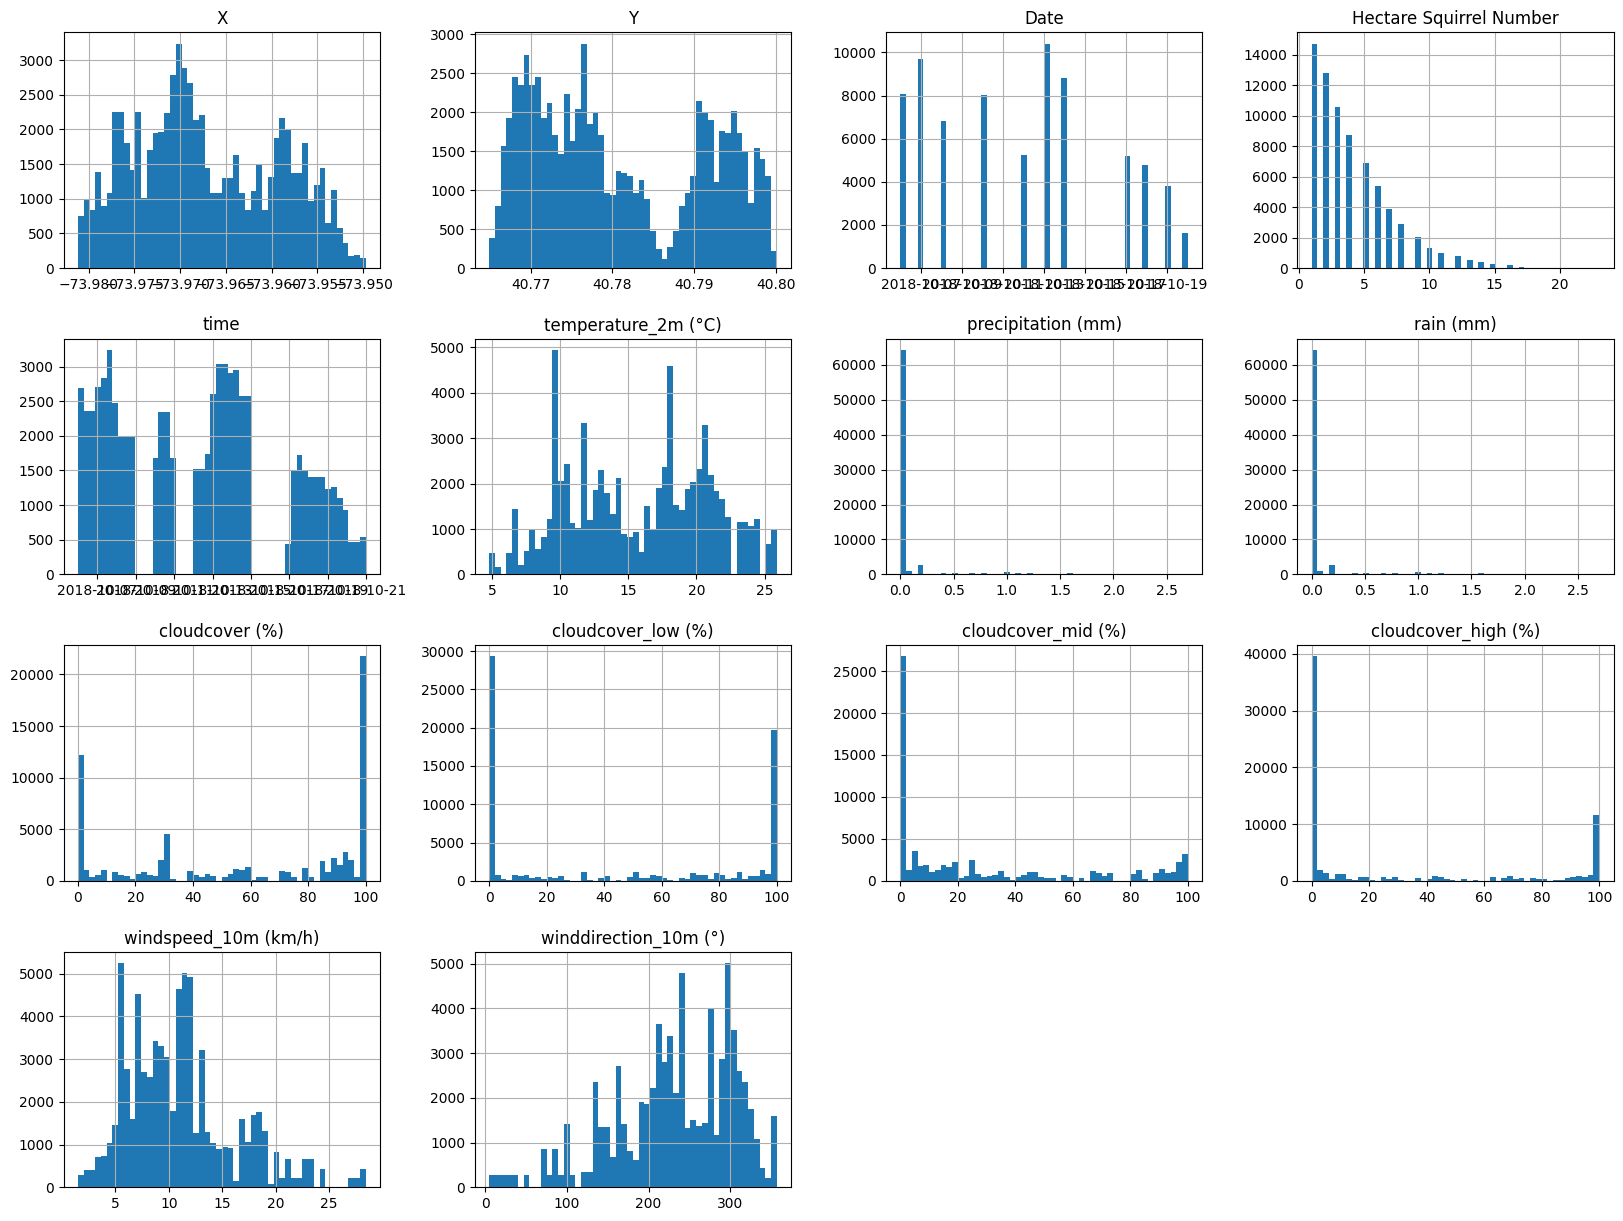

In [36]:
data.hist(bins=50, figsize=(20,15))

### *Splitting The Data Into Two Subsets*

-  The `train_set` containing 80% of the data for training and `test_set` containing 20% for testing, with the split being reproducible due to the specified `random_state`.

In [37]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

### *Saving Data to a CSV File*

In [38]:
data.to_csv("merged_data.csv", index=False)

### *Creating a Copy of the Training Set*

In [39]:
data = train_set.copy()

# **Data Exploration**

### *Heatmap of Squirrel Sightings in Central Park*

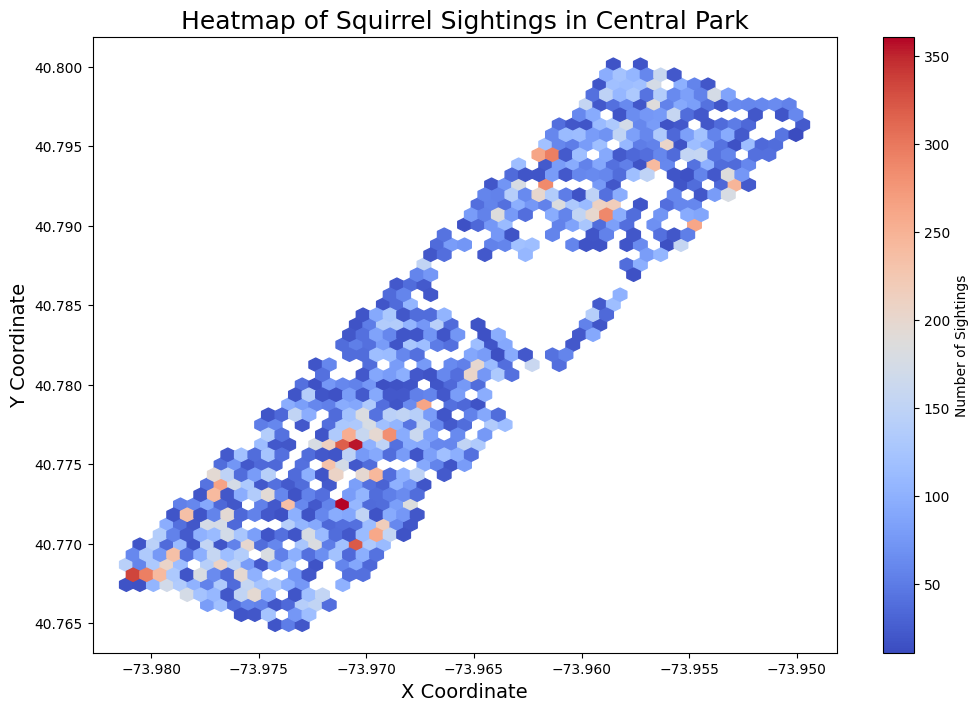

In [40]:
plt.figure(figsize=(12,8))
plt.hexbin(data['X'], data['Y'], gridsize=50, cmap='coolwarm', mincnt=1)
plt.colorbar(label='Number of Sightings')
plt.title('Heatmap of Squirrel Sightings in Central Park', fontsize=18)
plt.xlabel('X Coordinate', fontsize=14)
plt.ylabel('Y Coordinate', fontsize=14)
plt.show()

### *Correlation Matrix For Numerical Features*

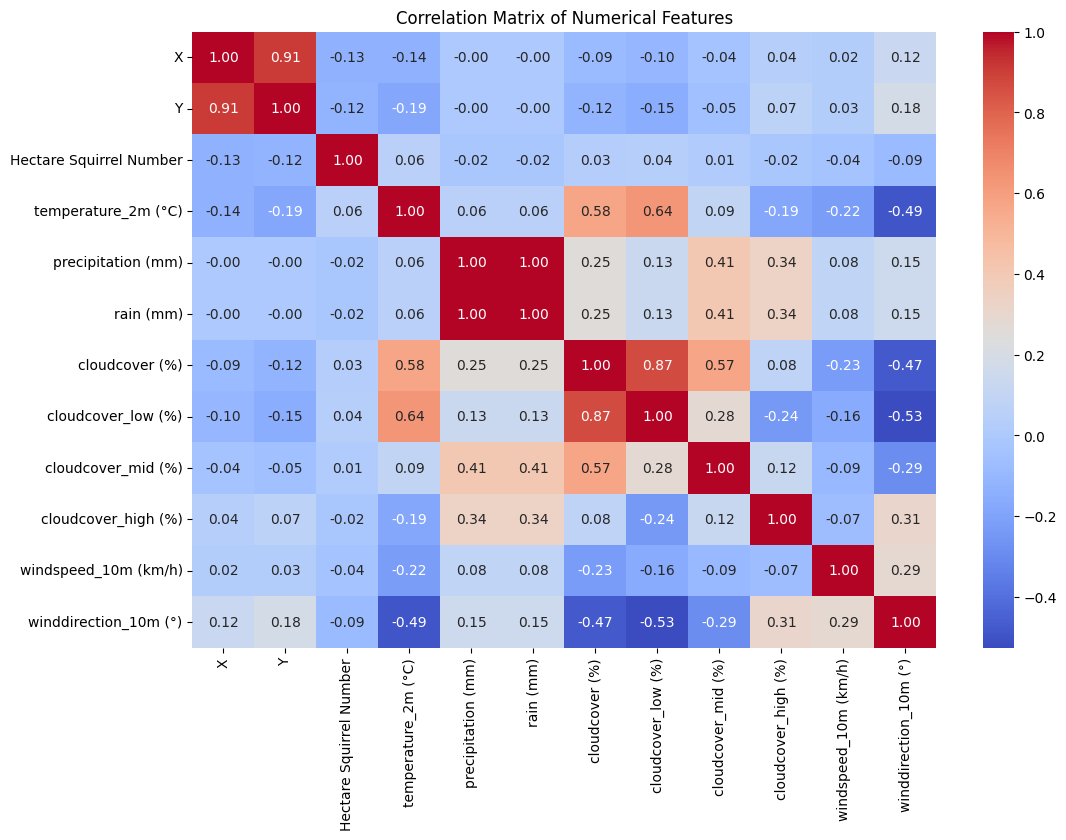

In [41]:
# Select only numerical columns
numerical_data = data.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


### *Average Squirrel Sighting Based Off Temperature*

/var/folders/gq/f3j82_650073w0x8z5ytw87w0000gp/T/ipykernel_65176/2660390221.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temperature_grouped = data.groupby('Temperature Range')['Hectare Squirrel Number'].mean().reset_index()
/var/folders/gq/f3j82_650073w0x8z5ytw87w0000gp/T/ipykernel_65176/2660390221.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Temperature Range', y='Hectare Squirrel Number', data=temperature_grouped, palette='viridis')


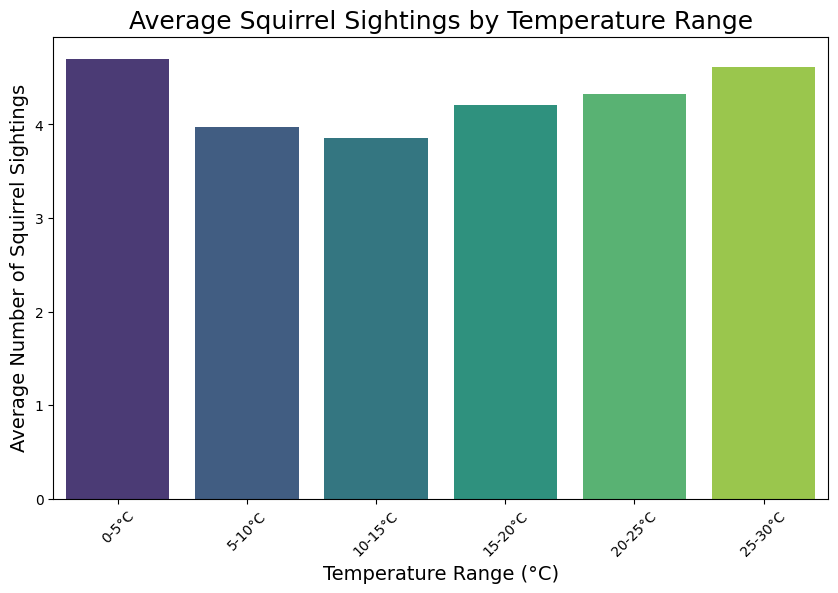

In [42]:
# Create temperature bins for grouping
bins = [0, 5, 10, 15, 20, 25, 30]
labels = ['0-5°C', '5-10°C', '10-15°C', '15-20°C', '20-25°C', '25-30°C']
data['Temperature Range'] = pd.cut(data['temperature_2m (°C)'], bins=bins, labels=labels)

# Group by temperature range and calculate the mean number of squirrel sightings
temperature_grouped = data.groupby('Temperature Range')['Hectare Squirrel Number'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(10,6))
sns.barplot(x='Temperature Range', y='Hectare Squirrel Number', data=temperature_grouped, palette='viridis')
plt.title('Average Squirrel Sightings by Temperature Range', fontsize=18)
plt.xlabel('Temperature Range (°C)', fontsize=14)
plt.ylabel('Average Number of Squirrel Sightings', fontsize=14)
plt.xticks(rotation=45)
plt.show()
